In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

In [2]:
# My mac
#data = pd.read_csv("/RawDataCSV/plotsClimateData_11092017.csv")
# My Linux desktop
data = pd.read_csv("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")


/opt/conda/envs/biospytial/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.SppN.mean()

5.1824128104220382

In [4]:
import geopandas as gpd

In [5]:
from django.contrib.gis import geos
from shapely.geometry import Point

In [6]:
data['geometry'] = data.apply(lambda z: Point(z.LON, z.LAT), axis=1)
new_data = gpd.GeoDataFrame(data)

## Let´s reproject to Alberts or something with distance

In [7]:
new_data.crs = {'init':'epsg:4326'}

### Uncomment to reproject
proj string taken from: http://spatialreference.org/

In [8]:
#new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

## The area is very big -> 35000 points. 
We need to make a subset of this


In [9]:
# COnsider the the following subregion
section = new_data[lambda x:  (x.LON > -90) & (x.LON < -85) & (x.LAT > 30) & (x.LAT < 35) ]

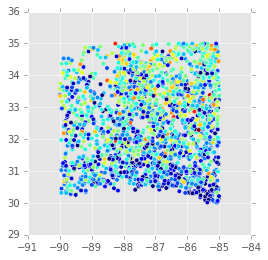

In [10]:
section.plot(column='SppN')

In [11]:
section.shape

(1841, 42)

In [12]:
section['newLon'] = section.apply(lambda c : c.geometry.x, axis=1)
section['newLat'] = section.apply(lambda c : c.geometry.y, axis=1)

/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Model Fitting Using a GLM 

The general model will have the form:
$$ Biomass(x,y) = \beta_1 AET + \beta_2 Age + Z(x,y) + \epsilon $$
Where:
$\beta_1$ and $\beta_2$ are model parameters, $Z(x,y)$ is the *Spatial Autocorrelation* process and $\epsilon \sim N(0,\sigma^2)$

In [23]:
##### OLD #######
len(data.lon)
#X = data[['AET','StandAge','lon','lat']]
#X = data[['SppN','lon','lat']]
X = data[['lon','lat']]
#Y = data['plotBiomass']
Y = data[['SppN']]
## First step in spatial autocorrelation
#Y = pd.DataFrame(np.zeros(len(Y)))
## Let´s take a small sample only for the spatial autocorrelation
#import numpy as np
#sample_size = 2000
#randindx = np.random.randint(0,X.shape[0],sample_size)
#nX = X.loc[randindx]
#nY = Y.loc[randindx]


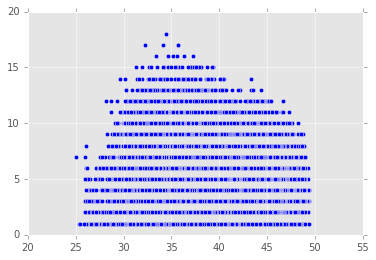

In [60]:
plt.scatter(new_data.lat,new_data.SppN)

## For new section

In [13]:
X = section[['newLon','newLat']]
#X = data[['lon','lat']]
Y = section['SppN']
sample_size = Y.shape[0]

In [43]:
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] ) + gf.kernels.Linear(2,active_dims=[0,1])

In [44]:
model = gf.gpr.GPR(X.as_matrix(),Y.as_matrix().reshape(sample_size,1).astype(float),k)

In [45]:
mm = k.compute_K_symm(X.as_matrix())

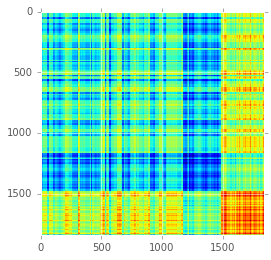

In [46]:
plt.imshow(mm)

In [47]:
model.likelihood.variance = 1
%time model.optimize()

CPU times: user 3min 34s, sys: 10.6 s, total: 3min 45s
Wall time: 1min 23s


      fun: 4632.4668922150358
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.76333146e-06,  -1.35486112e-05,   5.19970634e-05,
        -6.96790103e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 52
      nit: 46
   status: 0
  success: True
        x: array([  -1.79129671,  273.52279297,   53.95683454,    8.74346019])

In [48]:
pd.DataFrame(model.get_parameter_dict())

,name.kern.linear.variance,name.kern.matern12.lengthscales,name.kern.matern12.variance,name.likelihood.variance
0,0.154218,273.522794,53.956836,8.743621


In [125]:
a.split('\n')

['name.kern.\x1blengthscales\x1b transform:+ve prior:None',
 '[ 125.56749551]',
 'name.kern.\x1bvariance\x1b transform:+ve prior:None',
 '[ 41.06070014]',
 'name.likelihood.\x1bvariance\x1b transform:+ve prior:None',
 '[ 8.70375704]',
 '']

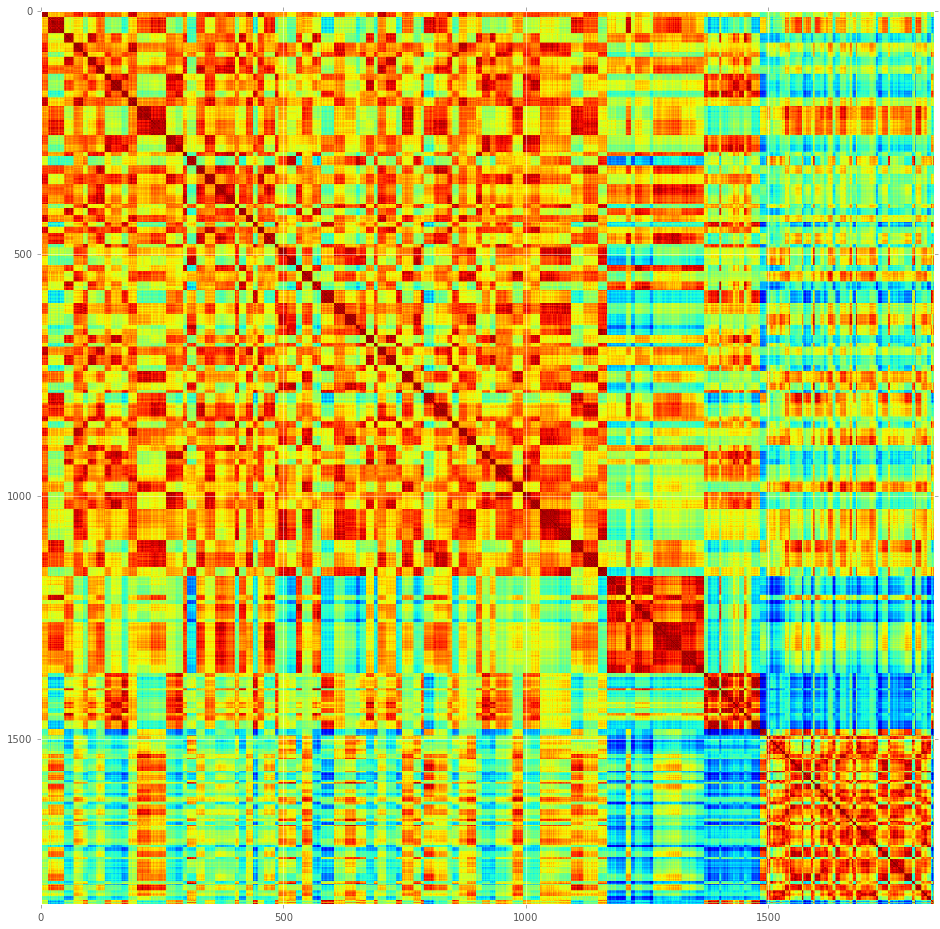

In [66]:
mm = k.compute_K_symm(X.as_matrix())
fig = plt.figure(figsize=(16,16), dpi= 80, facecolor='w', edgecolor='w')
plt.imshow(mm)

In [39]:
import scipy.stats as st

In [43]:
yyy = st.multivariate_normal(Y.as_matrix(),cov=mm)

In [103]:
w =  yyy.rvs()

In [83]:
42*42

-77

In [74]:
tens = np.ones(len(w))

In [107]:
## What is the probability of finding exactly 10 sp richness in the area?
varray = np.split(w[:42*42],42)

In [108]:
CC = np.hstack(varray)

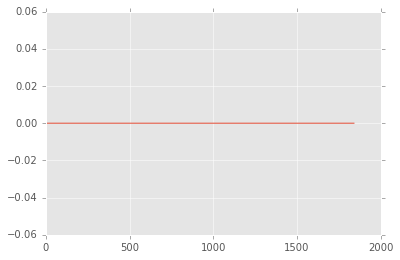

In [109]:
plt.plot(yyy.mean - Y.as_matrix())

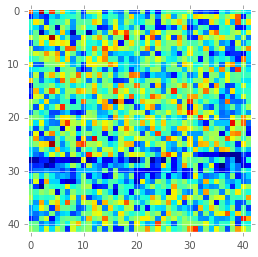

In [111]:
plt.imshow(CC.reshape(42,42),interpolation='none')

In [49]:
import numpy as np
Nn = 300
dsc = section
predicted_x = np.linspace(min(dsc.newLon),max(dsc.newLon),Nn)
predicted_y = np.linspace(min(dsc.newLat),max(dsc.newLat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()
#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()

In [50]:
predicted_coordinates.shape

(90000, 2)

In [51]:
means,variances = model.predict_y(predicted_coordinates)

In [52]:
means.shape

(90000, 1)

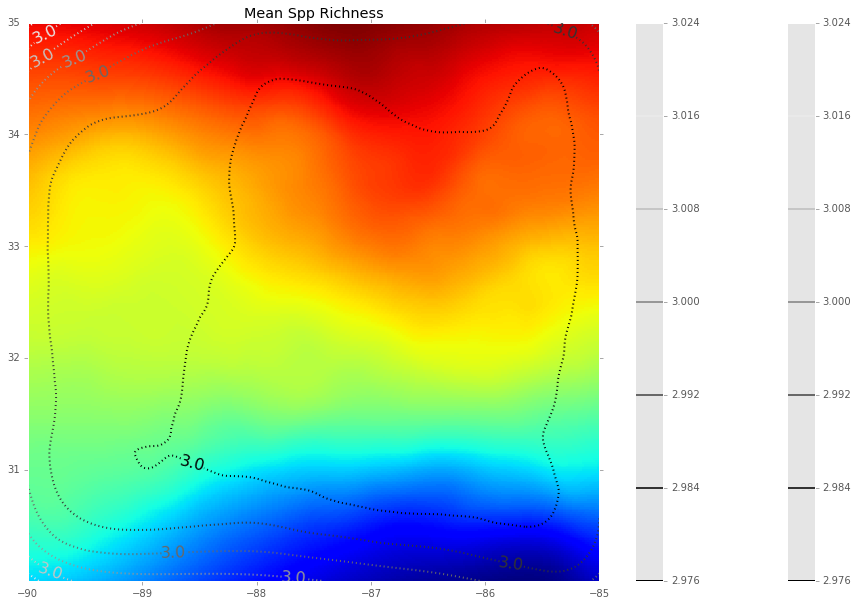

In [53]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.pcolormesh(Xx,Yy,means.reshape(Nn,Nn)) #,cmap=plt.cm.Greens)
cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
plt.colorbar()
#plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("Mean Spp Richness")
plt.colorbar()



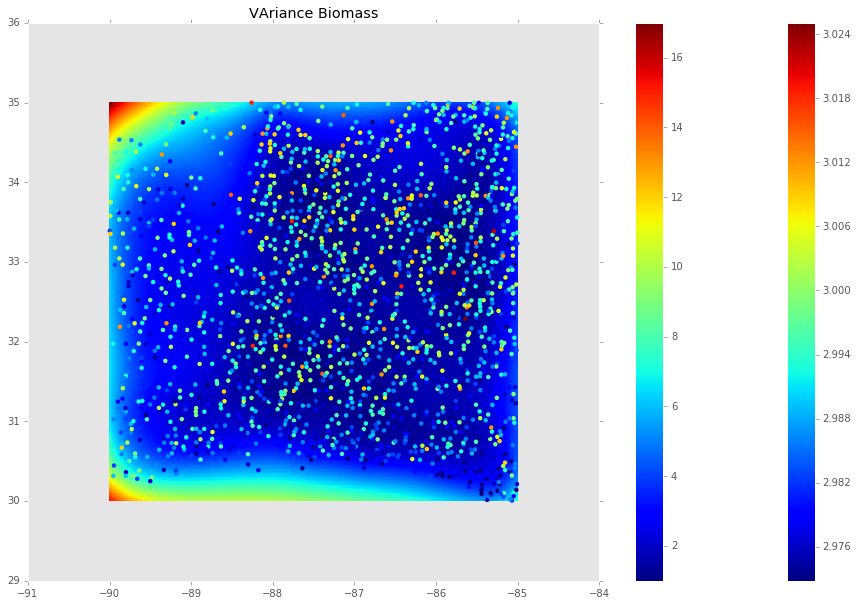

In [54]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
#plt.pcolor(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn))) #,cmap=plt.cm.Greens)
plt.pcolormesh(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn)))
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("VAriance Biomass")
plt.colorbar()

AttributeError: 'GeoDataFrame' object has no attribute 'error'

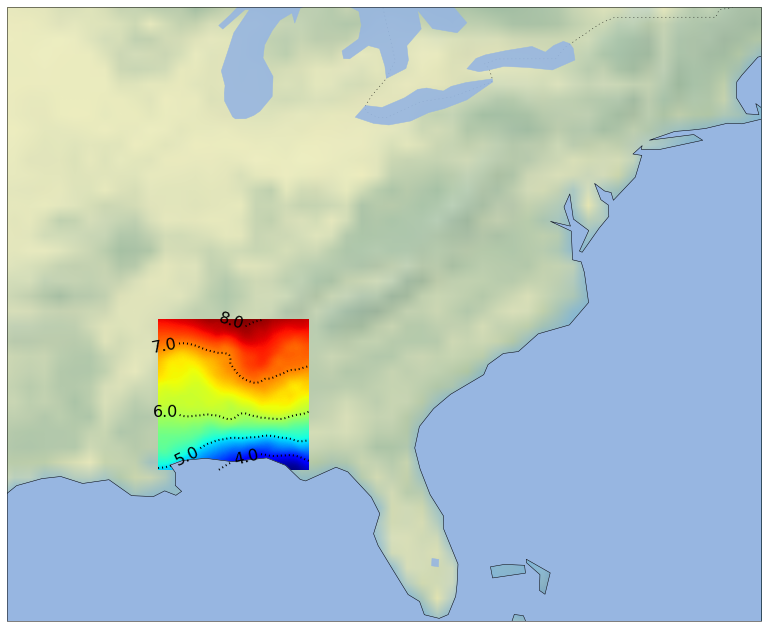

In [57]:
import cartopy 
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
#ax.set_extent([-100, -60, 20, 50])
ax.set_extent([-95, -70, 25, 45])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.9)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn),transform=proj )
#cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn),linewidths=2,colors='k',linestyles='dotted',levels=[4.0,5.0,6.0,7.0,8.0])
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
ax.scatter(new_data.lon,new_data.lat,c=new_data.error,edgecolors='',transform=proj,cmap=plt.cm.Greys,alpha=0.2)
plt.colorbar(mm)
plt.title("Predicted Species Richness")


#(x.LON > -90) & (x.LON < -80) & (x.LAT > 40) & (x.LAT < 50)

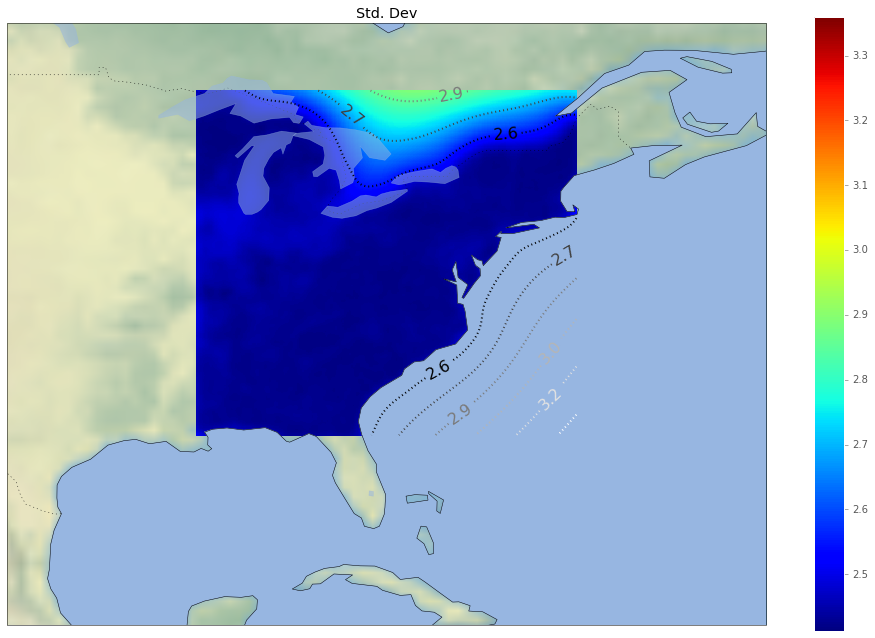

In [128]:
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
ax.set_extent([-100, -60, 20, 50])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),transform=proj )
cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
#cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn),linewidths=2,colors='k',linestyles='dotted',levels=[4.0,5.0,6.0,7.0,8.0])
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
#ax.scatter(new_data.lon,new_data.lat,c=new_data.SppN,edgecolors='',transform=proj,cmap=plt.cm.Greys_r)
plt.colorbar(mm)
plt.title("Std. Dev")


#(x.LON > -90) & (x.LON < -80) & (x.LAT > 40) & (x.LAT < 50)

## Model Analysis


In [52]:
model.get_parameter_dict()

{'name.kern.lengthscales': array([ 38.79738897]),
 'name.kern.variance': array([ 19.37473152]),
 'name.likelihood.variance': array([ 5.71903461])}

In [54]:
model.kern

Name,values,prior,constraint
kern.lengthscales,[ 38.79738897],None,+ve
kern.variance,[ 19.37473152],None,+ve


In [57]:
model.likelihood

Name,values,prior,constraint
likelihood.variance,[ 5.71903461],None,+ve


In [60]:
model.highest_parent

Name,values,prior,constraint
name.kern.lengthscales,[ 38.79738897],None,+ve
name.kern.variance,[ 19.37473152],None,+ve
name.likelihood.variance,[ 5.71903461],None,+ve


## Let's calculate the residuals

In [67]:
X_ = new_data[['LON','LAT']]
%time Y_hat = model.predict_y(X_)

CPU times: user 22min 25s, sys: 11.3 s, total: 22min 36s
Wall time: 21min 55s


In [93]:
pred_y = pd.DataFrame(Y_hat[0])
var_y = pd.DataFrame(Y_hat[1])

In [97]:
new_data['pred_y'] = pred_y
new_data['var_y'] = var_y

In [103]:
new_data= new_data.assign(error=lambda y : (y.SppN - y.pred_y)**2 )

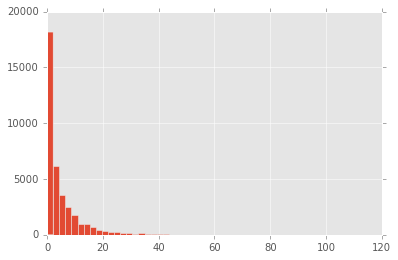

In [126]:
new_data.error.hist(bins=50)

In [111]:
print(new_data.error.mean())
print(new_data.error.std())

4.9272150963
7.21311831803


# Now for all the data

In [ ]:
new_data['newLon'] = section.apply(lambda c : c.geometry.x, axis=1)
new_data['newLat'] = section.apply(lambda c : c.geometry.y, axis=1)


X = new_data[['newLon','newLat']]
#X = data[['lon','lat']]
Y = new_data['SppN']
sample_size = Y.shape[0]
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] )
model = gf.gpr.GPR(X.as_matrix(),Y.as_matrix().reshape(sample_size,1).astype(float),k)
model.likelihood.variance = 10
%time model.optimize()
import numpy as np
Nn = 1000
dsc = new_data
predicted_x = np.linspace(min(dsc.newLon),max(dsc.newLon),Nn)
predicted_y = np.linspace(min(dsc.newLat),max(dsc.newLat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)

## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()


#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()
means,variances = model.predict_y(predicted_coordinates)
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.pcolormesh(Xx,Yy,means.reshape(Nn,Nn)) #,cmap=plt.cm.Greens)
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("Mean Spp Richness")
plt.colorbar()


In [130]:
k.ARD?